In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cmocean as cmo
import xarray as xr 
import cartopy
import cartopy.crs as ccrs
from scipy.io import loadmat
from scipy.interpolate import interp1d
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# LOAD BOTTOM SLOPES 
x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/CM26_global_slope.mat')
lon0 = x['lon'][:,0]
lat = x['lat'][:,0]
gamma0 = np.transpose(x['gamma']) # eastward 
alpha0 = np.transpose(x['alpha']) # northward 
roughness = np.transpose(x['rms_rough'])
# realign so lon-grid goes from 0-360
roughness = np.concatenate((roughness[:,lon0 >= 0], roughness[:,lon0 < 0]),axis=1)
alpha0 = np.concatenate((alpha0[:,lon0 >= 0], alpha0[:,lon0 < 0]),axis=1)
gamma0 = np.concatenate((gamma0[:,lon0 >= 0], gamma0[:,lon0 < 0]),axis=1)
lon = np.concatenate((lon0[lon0 >= 0], lon0[lon0 < 0]+360))

In [3]:
# LOAD EOFS
cm26_eof_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_EOF_analysis.nc'
cmEOF = xr.open_dataset(cm26_eof_path)
# shift EOF longitudes to match with modes 
lon01 = cmEOF.lon.data
eofu1 = np.concatenate((cmEOF.EOF1u[:,:,lon01 >= 0].data, cmEOF.EOF1u[:,:,lon01 < 0].data),axis=2)
eofv1 = np.concatenate((cmEOF.EOF1v[:,:,lon01 >= 0].data, cmEOF.EOF1u[:,:,lon01 < 0].data),axis=2)
lon1 = np.concatenate((lon01[lon01 >= 0], lon01[lon01 < 0]+360))
lat1 = cmEOF.lat.data
data_coords = {'depth': cmEOF.zl.data, 'latitude': lat1, 'longitude': lon1}
EOF1u = xr.DataArray(data=eofu1, dims=['depth','latitude','longitude'], coords=data_coords) 
EOF1v = xr.DataArray(data=eofu1, dims=['depth','latitude','longitude'], coords=data_coords) 
# trim in lat to match N2 data (maybe not needed)
EOF1u_trim = EOF1u[:,4:-25,:]
EOF1v_trim = EOF1v[:,4:-25,:]
lat_trim = lat1[4:-25]
EOF_z = cmEOF.zl.data

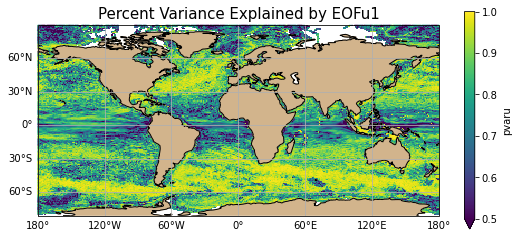

In [4]:
f, ax = plt.subplots(1,1,figsize=(9,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cmEOF.pvaru.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('viridis'), add_colorbar=True, vmin=0.5,vmax=1) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('Percent Variance Explained by EOFu1',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/eof_pct_var.jpg', dpi=300)

In [24]:
# LOAD CMN2
cm26_n2_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_N2_gsw.nc'
cmN2 = xr.open_dataset(cm26_n2_path)
lon02 = cmN2.xu_ocean.data
N2_s = np.concatenate((cmN2.N2[:,:,lon02 >= 0].data, cmN2.N2[:,:,lon02 < 0].data),axis=2)
N2_s_z = cmN2.depth.data
lon2 = np.concatenate((lon02[lon02 >= 0], lon02[lon02 < 0]+360))
lat2 = cmN2.yu_ocean.data

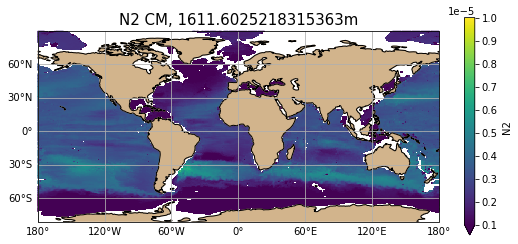

In [11]:
z_i = 30
f, ax = plt.subplots(1,1,figsize=(9,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cmN2.N2[z_i].plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('viridis'),add_colorbar=True, vmin=0.000001,vmax=0.00001) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('N2 CM, ' + str(cmN2.depth[z_i].data) + 'm',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/eof_pct_var.jpg', dpi=300)

In [12]:
# load stratification (for now match N2 to CM2.6 grid)
x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/global_1deg_N2smooth_slope.mat') # global_n2_2deg_slope.mat')
N2_lon = x['lon'][:,0]    
N2_lon[N2_lon < 0] = 360-np.abs(N2_lon[N2_lon < 0])
N2_lat = x['lat'][:,0]   
N2 = x['N2']      
N2 = np.concatenate((N2[N2_lon < 180,:,:], N2[N2_lon > 180,:,:]),axis=0)
N2_lon = np.concatenate((N2_lon[N2_lon < 180], N2_lon[N2_lon > 180]))
N2_z = -1.*x['dep'][:,0]

In [18]:
N2_z[58]

-1600.0

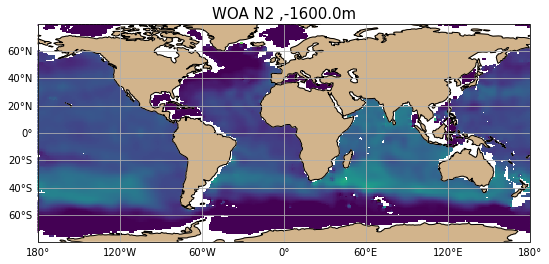

In [19]:
z_i = 58
f, ax = plt.subplots(1,1,figsize=(9,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(N2_lon,N2_lat,np.transpose(N2[:,:,z_i]),transform=ccrs.PlateCarree(),\
          cmap=plt.get_cmap('viridis'),vmin=0.000001,vmax=0.00001)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('WOA N2 ,' + str(N2_z[z_i]) + 'm',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/eof_pct_var.jpg', dpi=300)

In [27]:
# DEFINE NEW GRID TO SMOOTH TO (faster computation time...at a desired resolution)
lon_step = 2
lat_step = 2 
z_step = 100
lon_grid = np.arange(0,360,lon_step)
lat_grid = np.arange(-78,78,lat_step)
z_grid = EOF_z # np.arange(0,6000,z_step)
N2_out = np.nan*np.ones((len(z_grid),len(lat_grid),len(lon_grid)))
EOFu_out = np.nan*np.ones((len(z_grid),len(lat_grid),len(lon_grid)))
EOFv_out = np.nan*np.ones((len(z_grid),len(lat_grid),len(lon_grid)))
alpha_out = np.nan*np.ones((len(lat_grid),len(lon_grid)))
gamma_out = np.nan*np.ones((len(lat_grid),len(lon_grid)))
for i in tqdm(range(len(lon_grid))):
    for j in range(len(lat_grid)):
        t_lon = lon_grid[i]
        t_lat = lat_grid[j]
        # lat/lon = gamma,alpha
        # lat_trim/lon1 = EOFs
        # N2_lat/N2_lon = N2
        s_lon_in = np.where((lon > (t_lon-lon_step/2)) & (lon < (t_lon+lon_step/2)))[0]
        s_lat_in = np.where((lat > (t_lat-lat_step/2)) & (lat < (t_lat+lat_step/2)))[0]
        
        E_lon_in = np.where((lon1 > (t_lon-lon_step/2)) & (lon1 < (t_lon+lon_step/2)))[0]
        E_lat_in = np.where((lat_trim > (t_lat-lat_step/2)) & (lat_trim < (t_lat+lat_step/2)))[0]
        
        # N_lon_in = np.where((N2_lon > (t_lon-lon_step)) & (N2_lon < (t_lon+lon_step)))[0]
        # N_lat_in = np.where((N2_lat > (t_lat-lat_step)) & (N2_lat < (t_lat+lat_step)))[0]
        # N2_int = np.nanmean(np.nanmean(N2[N_lon_in][:,N_lat_in,:],axis=0),axis=0)
        
        N_lon_in = np.where((lon2 > (t_lon-lon_step/2)) & (lon2 < (t_lon+lon_step/2)))[0]
        N_lat_in = np.where((lat2 > (t_lat-lat_step/2)) & (lat2 < (t_lat+lat_step/2)))[0]
        N2_int = np.nanmean(np.nanmean(N2_s[:,N_lat_in][:,:,N_lon_in],axis=1),axis=1)
        
        if len(np.where(~np.isnan(N2_int))[0]) < 5:
            continue
            
        # -- print('good')
        # -- adjust N2 grid 
        z_in = 1*N2_s_z[~np.isnan(N2_int)]
        good = np.where(z_grid <= np.nanmax(z_in))[0]
        N2_out[good,j,i] = np.interp(z_grid[good],1*N2_s_z, N2_int)
        # N2_out[:,j,i] = N2_int
        
        alpha_out[j,i] = np.nanmean(np.nanmean(alpha0[s_lat_in][:,s_lon_in],axis=0),axis=0)
        gamma_out[j,i] = np.nanmean(np.nanmean(gamma0[s_lat_in][:,s_lon_in],axis=0),axis=0)
        
        EOFu_int = EOF1u_trim[:,E_lat_in][:,:,E_lon_in]
        deepest_i = np.nan*np.ones((len(E_lat_in),len(E_lon_in)))
        for k in range(len(E_lat_in)):
            for l in range(len(E_lon_in)):
                # -- flip sign before average for a mean EOF 
                if np.nanmean(EOFu_int[0:4,k,l]) < 0:
                    EOFu_int[:,k,l] = -1*EOFu_int[:,k,l]
                
                # -- max depth of EOF (only average EOFs extending to nearby depth)
                if len(np.where(~np.isnan(EOFu_int[:,k,l]))[0]) > 10:
                    deepest_i[k,l] = np.where(~np.isnan(EOFu_int[:,k,l]))[0][-1]
        deepest = np.nanmax(deepest_i)
        matching_ind = np.where(deepest_i >= deepest-3)
        # -- new set of EOFs to average over 
        EOFu_int_2 = EOFu_int[:,matching_ind[0],matching_ind[1]]
        contr_prof = np.shape(EOFu_int_2)[1]*np.shape(EOFu_int_2)[2]
        # -- average across all EOFs satisfying depth requirement
        # EOFu_out[:,j,i] = np.nanmean(np.nanmean(EOFu_int[:,matching_ind[0],matching_ind[1]],axis=1),axis=1)
        # -- OR -- average only if there are enough EOFs at each depth 
        for m in range(np.shape(EOFu_int_2)[0]):
            if np.sum(~np.isnan(EOFu_int_2[m,:,:])) > (contr_prof-3):
                EOFu_out[m,j,i] = np.nanmean(EOFu_int_2[m,:,:])
        
        # EOFu_out[good,j,i] = np.interp(z_grid[good],EOF_z,EOFu_int)   
        # EOFv_int = np.nanmean(np.nanmean(EOF1v_trim[:,E_lat_in][:,:,E_lon_in],axis=1),axis=1)
        # EOFv_out[:,j,i] = EOFv_int
        # EOFv_out[good,j,i] = np.interp(z_grid[good],EOF_z,EOFv_int)   

100%|██████████| 180/180 [07:20<00:00,  2.45s/it]


In [28]:
# construct output data array
data_coords = {'depth': z_grid, 'latitude': lat_grid, 'longitude': lon_grid}
N2_da = xr.DataArray(data=N2_out, dims=['depth','latitude','longitude'], coords=data_coords) 
EOFu_da = xr.DataArray(data=EOFu_out, dims=['depth','latitude','longitude'], coords=data_coords) 
EOFv_da = xr.DataArray(data=EOFv_out, dims=['depth','latitude','longitude'], coords=data_coords) 
data_coords = {'latitude': lat_grid, 'longitude': lon_grid}
alpha_da = xr.DataArray(data=alpha_out, dims=['latitude','longitude'], coords=data_coords) 
gamma_da = xr.DataArray(data=gamma_out, dims=['latitude','longitude'], coords=data_coords) 

In [29]:
pct_decay = np.nan*np.ones((len(EOFu_da.latitude),len(EOFu_da.longitude)))
for i in tqdm(range(len(EOFu_da.longitude))):
    for j in range(len(EOFu_da.latitude)):
        if len(np.where(~np.isnan(EOFu_da[:,j,i]))[0]) > 5:
            gi = np.where(~np.isnan(EOFu_da[:,j,i]))[0]
            pct_decay[j,i] = np.nanmean(EOFu_da[gi[-4:],j,i]) / np.nanmean(EOFu_da[0:4,j,i])

100%|██████████| 180/180 [00:16<00:00, 10.81it/s]


In [30]:
data_coords = {'latitude': lat_grid, 'longitude': lon_grid}
pct_decay_da = xr.DataArray(data=pct_decay, dims=['latitude','longitude'], coords=data_coords) 

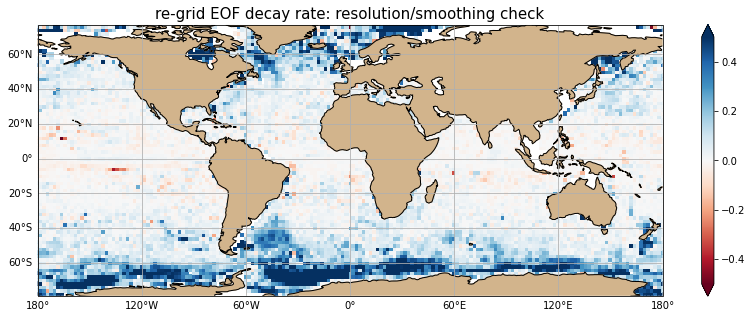

In [31]:
f, ax = plt.subplots(1,1,figsize=(14,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
# N2_da.sel(depth=z_grid[5]).plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('jet'), add_colorbar=True, vmin=0,vmax=0.0001) 
# alpha_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('viridis'), add_colorbar=True, vmin=-0.01,vmax=0.01) 
pct_decay_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu'), add_colorbar=True, vmin=-0.5,vmax=0.5) 
# ax.scatter(320.5,32.5,color='m')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('re-grid EOF decay rate: resolution/smoothing check',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/eof_decay_smooth_2deg.jpg', dpi=300)

In [32]:
lon_check = 310
lat_check = -68
i1 = np.where((lon1 > lon_check) & (lon1 < lon_check+1))[0][0]
j1 = np.where((lat_trim >= lat_check) & (lat_trim < lat_check+0.5))[0][0]
i2 = np.where((lon_grid >= lon_check) & (lon_grid <= lon_check+1))[0][0]
j2 = np.where((lat_grid >= lat_check) & (lat_grid <= lat_check+1))[0][0]
print(i2)
print(j2)
print(str(lon1[i1]) + ', ' + str(lat_trim[j1]))
print(str(lon_grid[i2]) + ', ' + str(lat_grid[j2]))

155
5
310.0499999999947, -67.59203827659981
310, -68


In [33]:
np.shape(N2_out)
N2_out[:,j2,i2]
z_grid[-12]

3092.1171875

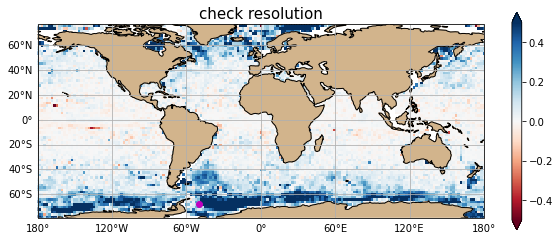

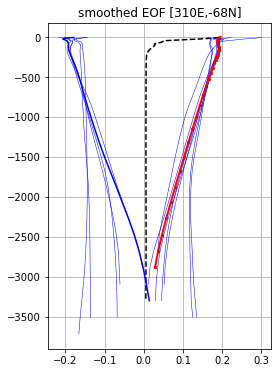

In [34]:
f, ax = plt.subplots(1,1,figsize=(10,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
pct_decay_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu'), add_colorbar=True, vmin=-0.5,vmax=0.5) 
ax.scatter(lon_check,lat_check,color='m')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('check resolution',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False

f, ax = plt.subplots(1,1,figsize=(4,6))
ax.plot(2000*N2_out[:,j2,i2]+0.005,-1*z_grid,linestyle='--',color='k')
ax.plot(EOF1u_trim[:,j1,i1],-1*EOF_z,color='b')
ax.plot(-1*EOF1u_trim[:,j1-1,i1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(-1*EOF1u_trim[:,j1+1,i1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(-1*EOF1u_trim[:,j1-2,i1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(1*EOF1u_trim[:,j1+2,i1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(-1*EOF1u_trim[:,j1-3,i1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(-1*EOF1u_trim[:,j1+3,i1],-1*EOF_z,color='b',linewidth=0.5)

ax.plot(EOF1u_trim[:,j1,i1-1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(EOF1u_trim[:,j1,i1+1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(EOF1u_trim[:,j1,i1-2],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(-1*EOF1u_trim[:,j1,i1+2],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(EOF1u_trim[:,j1,i1-3],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(EOF1u_trim[:,j1,i1+3],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(EOFu_out[:,j2,i2],-1*z_grid,color='r',linewidth=2)
ax.scatter(EOFu_out[:,j2,i2],-1*z_grid,color='r',s=5)
# ax.set_xlim([0,0.3])
ax.set_title('smoothed EOF [' + str(lon_check) + 'E,' + str(lat_check) + 'N]')
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/eof_decay_smooth_2deg_profile.jpg', dpi=300)

In [37]:
ds = xr.Dataset(
    data_vars=dict(
        N2=(['z','lat','lon'], N2_out),
        EOFu=(['z','lat','lon'], EOFu_out),
        EOFv=(['z','lat','lon'], EOFv_out),
        alpha=(['lat','lon'], alpha_out),
        gamma=(['lat','lon'], gamma_out),
    ),
    coords=dict(
        z=(['z'],z_grid),
        lat=(['lat'],lat_grid),
        lon=(['lon'],lon_grid),
    )
)

In [38]:
ds.to_netcdf(path='/Users/jakesteinberg/Documents/CPT/vertical_structure/CM_comparisons/prep_for_modes_cmN_2deg.nc')

In [35]:
N2_out[:,j2,i2]

array([9.36848360e-05, 8.29665458e-05, 6.63398999e-05, 4.44613498e-05,
       2.37169880e-05, 2.19747836e-05, 1.96858730e-05, 1.32189997e-05,
       1.10826473e-05, 1.17700890e-05, 1.09064699e-05, 9.69315196e-06,
       7.95209026e-06, 5.96536828e-06, 4.48711329e-06, 3.01470675e-06,
       2.18007953e-06, 1.27216180e-06, 1.01732028e-06, 6.74690530e-07,
       6.24201634e-07, 4.98378514e-07, 5.00757565e-07, 4.34988797e-07,
       4.23394030e-07, 4.00023881e-07, 3.60529676e-07, 3.28441403e-07,
       3.14297712e-07, 3.10025040e-07, 3.18921712e-07, 3.36252503e-07,
       3.62895179e-07, 3.98867063e-07, 4.51876874e-07, 5.07799556e-07,
       4.84166716e-07, 3.46100514e-07, 2.37352576e-07, 1.68359478e-07,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan])